In [1]:

# -------------------- 1. Imports --------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


# -------------------- 2. Reprodutibilidade --------------------
tf.keras.utils.set_random_seed(42)
tf.keras.backend.clear_session()

# -------------------- 3. Carregar e Limpar Dataset --------------------
df = pd.read_csv("/content/drive/MyDrive/household_power_consumption.txt", sep=';', na_values='?', low_memory=False)

df["Datetime"] = pd.to_datetime(df["Date"] + " " + df["Time"], format="%d/%m/%Y %H:%M:%S")
df = df[["Datetime", "Global_active_power"]].dropna()
df = df.set_index("Datetime").resample("H").mean().dropna()

# -------------------- 4. Normalizar --------------------
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[["Global_active_power"]].values)

# -------------------- 5. Função para Criar Janelas --------------------
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

window_size = 24  # 24h = 1 dia
X, y = create_sequences(scaled_data, window_size)

# -------------------- 6. Dividir em Treino/Teste --------------------
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# -------------------- 7. Criar Modelo LSTM Simples --------------------
model = Sequential([
    LSTM(64, input_shape=(window_size, 1)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

# -------------------- 8. EarlyStopping --------------------
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# -------------------- 9. Treinamento --------------------
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)



<ipython-input-1-505374427>:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.set_index("Datetime").resample("H").mean().dropna()
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
503/503 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.0163 - val_loss: 0.0120
Epoch 2/50
503/503 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0103 - val_loss: 0.0112
Epoch 3/50
503/503 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0101 - val_loss: 0.0103
Epoch 4/50
503/503 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0097 - val_loss: 0.0099
Epoch 5/50
503/503 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0096 - val_loss: 0.0098
Epoch 6/50
503/503 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0094 - val_loss: 0.0097
Epoch 7/50
503/503 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0094 - val_loss: 0.0097
Epoch 8/50
503/503 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0093 - val_loss: 0.0096
Epoch 9/50
503/503 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0093 - val_loss: 0.0096
Epoch 10/50
503/503 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0093 - val_loss: 0.0096
Epoch 11/50
503/503 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0093 - val_loss: 0.0096
Epoch 12/50
503/503 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step

TypeError: got an unexpected keyword argument 'squared'

158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
MAE: 0.34077814878919055
RMSE: 0.503541553447154
R²: 0.5179196637723621


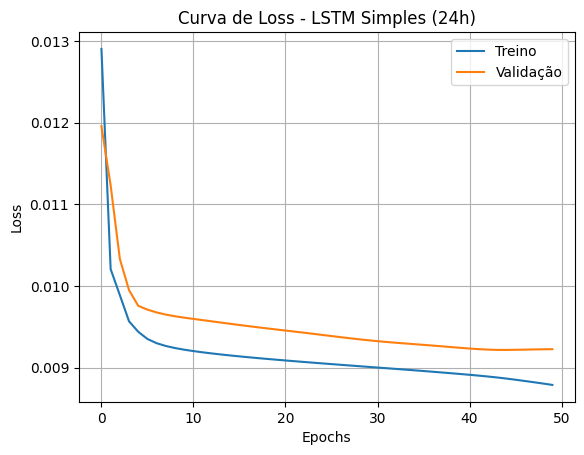

In [2]:
# -------------------- 10. Avaliação --------------------
y_pred = model.predict(X_test)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = scaler.inverse_transform(y_pred)

mae = mean_absolute_error(y_test_inv, y_pred_inv)
rmse = mean_squared_error(y_test_inv, y_pred_inv) ** 0.5
r2 = r2_score(y_test_inv, y_pred_inv)

print("MAE:", mae)
print("RMSE:", rmse)
print("R²:", r2)

# -------------------- 11. Plot da Curva de Loss --------------------
plt.plot(history.history["loss"], label="Treino")
plt.plot(history.history["val_loss"], label="Validação")
plt.title("Curva de Loss - LSTM Simples (24h)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


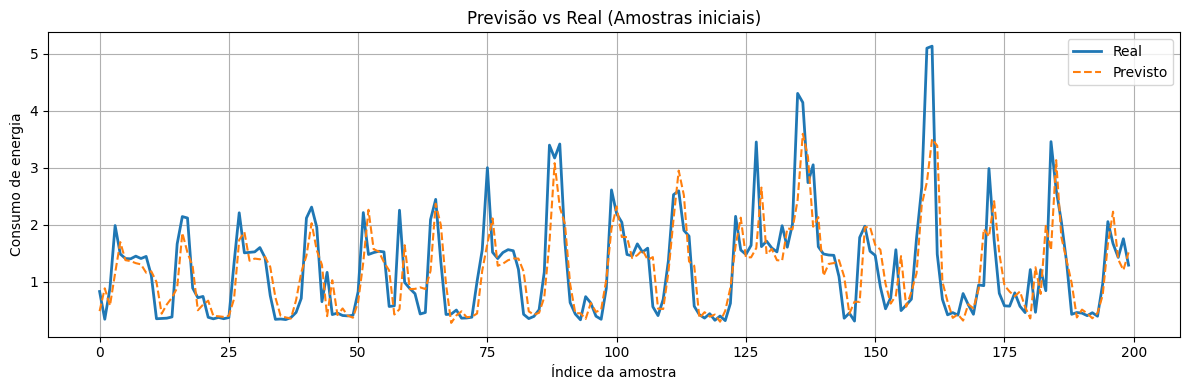

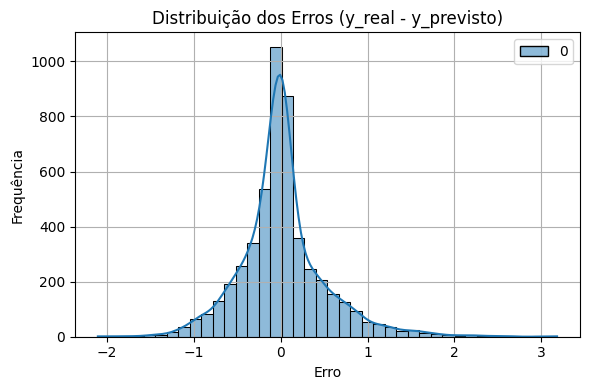

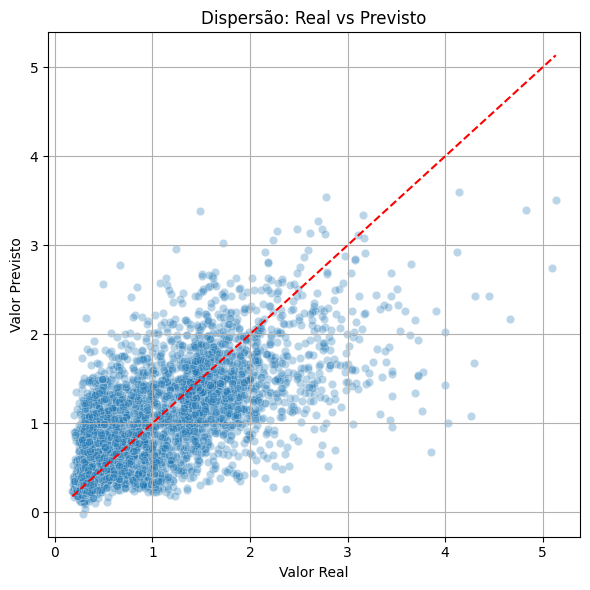

In [3]:
import seaborn as sns

# Gráfico 1: Curva de previsão (real vs previsto)
plt.figure(figsize=(12, 4))
plt.plot(y_test_inv[:200], label='Real', linewidth=2)
plt.plot(y_pred_inv[:200], label='Previsto', linestyle='--')
plt.title('Previsão vs Real (Amostras iniciais)')
plt.xlabel('Índice da amostra')
plt.ylabel('Consumo de energia')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Gráfico 2: Histograma dos erros
errors = y_test_inv - y_pred_inv
plt.figure(figsize=(6, 4))
sns.histplot(errors, kde=True, bins=40, color='gray')
plt.title('Distribuição dos Erros (y_real - y_previsto)')
plt.xlabel('Erro')
plt.ylabel('Frequência')
plt.grid(True)
plt.tight_layout()
plt.show()

# Gráfico 3: Dispersão entre real e previsto
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test_inv.flatten(), y=y_pred_inv.flatten(), alpha=0.3)
plt.plot([min(y_test_inv), max(y_test_inv)], [min(y_test_inv), max(y_test_inv)], 'r--')  # linha ideal
plt.title('Dispersão: Real vs Previsto')
plt.xlabel('Valor Real')
plt.ylabel('Valor Previsto')
plt.grid(True)
plt.tight_layout()
plt.show()